In [1]:
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
from os.path import isfile
import gzip
import pickle
import time

In [2]:
##################### MNIST dataset and labels fetcher #####################

filename = [
    ["training_images", "train-images-idx3-ubyte.gz"],
    ["test_images", "t10k-images-idx3-ubyte.gz"],
    ["training_labels", "train-labels-idx1-ubyte.gz"],
    ["test_labels", "t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(
                f.read(), np.uint8, offset=16).reshape(-1, 28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist, f)
    print("Save complete.")

def is_downloaded():
    return any(map(lambda name: isfile(name[1]), filename))

def is_saved():
    return isfile("mnist.pkl")

def load_mnist():
    if not is_downloaded():
        download_mnist()
    if not is_saved():
        save_mnist()
    with open("mnist.pkl", 'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [3]:
def to_categorical(y, dim):
    """
    it creates a zeros array of length 10 for each label, then puts '1' on
    the index equals label's value.
    ex:
    a value of 5 is equivalent to: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    """
    layers = np.zeros((y.shape[0], dim))
    layers[np.arange(y.shape[0]), y] = 1
    return layers

In [4]:
def plotter(y_values, legend, title_name):
    fig = plt.figure()
    plot = fig.add_subplot(1, 1, 1)
    plot.plot(y_values)
    plot.set_xlim(-1, len(y_values))
    plot.set_xticklabels(range(-1, len(y_values)+1, 2))
    plt.legend([legend])
    plt.title('{} Graph (values in range 0 to 1)'.format(title_name))
    plt.xlabel('epoch')
    plt.show()

In [5]:
##################### fetch the mnist dataset #####################
x_train, y_train, x_test, y_test = load_mnist()

Download complete.
Save complete.


In [6]:
# data preparation/normalization

# normalize labels for easy use with the activation function with of last layer
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# we transform the dataset image to be in range 0-1 instead of 0-255
x_train = x_train/255
x_test = x_test/255

In [7]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_derivative(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)

def softmax(x): # Si
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=0)

def softmax_derivative(x): # dSi = Si * (1 - Si)
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))

In [8]:
def create_model(sizes):
    input_layer = sizes[0]
    hl_1 = sizes[1]
    hl_2 = sizes[2]
    output_layer = sizes[3]

    model = {
        'W1': np.random.randn(hl_1, input_layer) * np.sqrt(1. / hl_1),
        'W2': np.random.randn(hl_2, hl_1) * np.sqrt(1. / hl_2),
        'W3': np.random.randn(output_layer, hl_2) * np.sqrt(1. / output_layer),
        'b1': np.random.randn(hl_1) * np.sqrt(1. / hl_1),
        'b2': np.random.randn(hl_2) * np.sqrt(1. / hl_2),
        'b3': np.random.randn(output_layer) * np.sqrt(1. / output_layer)
    }

    return model

In [9]:
def forward_pass(model, input_layer):
    # input layer activations becomes sample
    model['A0'] = input_layer

    # input layer to hidden layer 1
    model['Z1'] = np.dot(model["W1"], model['A0']) + model["b1"]
    model['A1'] = sigmoid(model['Z1'])

    # hidden layer 1 to hidden layer 2
    model['Z2'] = np.dot(model["W2"], model['A1']) + model["b2"]
    model['A2'] = sigmoid(model['Z2'])

    # hidden layer 2 to output layer
    model['Z3'] = np.dot(model["W3"], model['A2']) + model["b3"]
    model['A3'] = softmax(model['Z3'])

    return model['A3']

In [10]:
def backward_pass(model, y_train, output):
    change_w = {}

    # Calculate W3 update
    error = 2 * (output - y_train) / output.shape[0] * softmax_derivative(model['Z3'])
    change_w['W3'] = np.outer(error, model['A2'])
    change_w['b3'] = error

    # Calculate W2 update
    error = np.dot(model['W3'].T, error) * sigmoid_derivative(model['Z2'])
    change_w['W2'] = np.outer(error, model['A1'])
    change_w['b2'] = error

    # Calculate W1 update
    error = np.dot(model['W2'].T, error) * sigmoid_derivative(model['Z1'])
    change_w['W1'] = np.outer(error, model['A0'])
    change_w['b1'] = error

    return change_w

In [11]:
def update_parameters(model, changes_to_w, learning_rate):
    for key, value in changes_to_w.items():
        model[key] -= learning_rate * value

In [12]:
def evaluate_model(model, x_test, y_test):
    accuracy = []
    losses = []

    for x, y in zip(x_test, y_test):
        output = forward_pass(model, x)

        accu = np.argmax(output)
        loss = y - output

        accuracy.append(accu == np.argmax(y))
        losses.append(np.linalg.norm(loss, 2))

    return np.mean(accuracy), np.mean(losses)

In [13]:
def train(model, x_train, y_train, x_test, y_test, epochs=10, learning_rate=0.01):
    history = {
        "loss": [],
        "accuracy": []
    }
    start_time = time.time()
    for iteration in range(epochs):
        for x,y in zip(x_train, y_train):
            output = forward_pass(model, x)
            changes_to_w = backward_pass(model, y, output)
            update_parameters(model, changes_to_w, learning_rate)

        accuracy, loss = evaluate_model(model, x_test, y_test)
        history["accuracy"].append(accuracy)
        history["loss"].append(loss)
        print('Epoch: {0}, Spent time: {1:.2f}s, Accuracy: {2:.2f}%, Loss: {3:.2f}%'.format(
            iteration+1, time.time() - start_time, accuracy * 100, loss * 100
        ))
    return history

In [ ]:
model = create_model([784, 128, 64, 10])
history = train(model, x_train, y_train, x_test, y_test, 17)

Epoch: 1, Spent time: 36.59s, Accuracy: 48.11%, Loss: 80.87%
Epoch: 2, Spent time: 73.67s, Accuracy: 63.07%, Loss: 72.19%
Epoch: 3, Spent time: 112.21s, Accuracy: 73.19%, Loss: 65.73%
Epoch: 4, Spent time: 149.16s, Accuracy: 75.92%, Loss: 58.05%


In [ ]:
##################### accuracy plot #####################

plotter(history['accuracy'], 'accuracy', 'Accuracy')

In [ ]:
##################### loss plot #####################

plotter(history['loss'], 'loss', 'Loss')

label is: 2
expected: 2


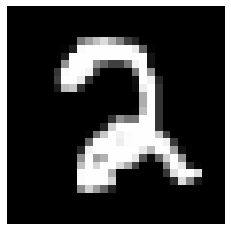

In [ ]:
##################### manual testing #####################

# change this number in range 0 to 9999 to test different images
selected_index = 892

print("label is: {}".format(np.argmax(y_test[selected_index]))) # selected label
print("expected: {}".format(np.argmax(forward_pass(model, x_test[selected_index]))))

img = x_test[selected_index].reshape(28,28)
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show() # Show the image